In [14]:
import math
import numpy as np
import re
import string
import cv2
import os
import errno
import random

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
inputWidth = 18
inputHeight = 22

In [44]:
#reload model for further training
from numpy import loadtxt
from keras.models import load_model

from numpy import loadtxt
from keras.models import load_model

from keras import layers
from keras import models
from keras import optimizers

from keras.utils import plot_model
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
 
# load model
number_loaded_model = load_model('numberRealModel.h5')
# summarize model.
number_loaded_model.summary()
# load dataset

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 20, 16, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 8, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 6, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 3, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 1, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

In [40]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [2]:
def blurData(grayImage):
    kernelSize = random.randrange(1, 3+1, 2)
    return cv2.GaussianBlur(grayImage,(kernelSize,kernelSize),cv2.BORDER_DEFAULT)

realDataGen = ImageDataGenerator(
                              brightness_range=[0.8,1.0],
                              rotation_range = 10,
                              zoom_range = [0.8,1],
#                               validation_split = 0.2,
#                               width_shift_range = 0.2,
#                              height_shift_range = 0.2,
                             shear_range=0.2,
#                              validation_split = 0.2,
                             preprocessing_function = blurData
    
                            )


In [8]:
# second round of training with real data from the world
dataPath = "./realData"
numberDataPath = dataPath + "/parkingNumbers"

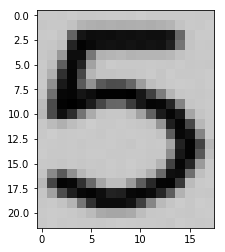

In [29]:
numberLabels = ['0','1','2','3','4','5','6','7','8','9']
numberDataDictionary = {"image" : [] , "vector": [], "label": []}


for file in os.listdir(numberDataPath):
    if(file.endswith('.png')):
        image = cv2.imread(numberDataPath + '/' + file)
        image = cv2.resize(image,(inputWidth,inputHeight))

        grayImage = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        grayImage3 = np.repeat(grayImage[..., np.newaxis], 3, -1)
        plt.imshow(grayImage3)
#         imageBlur = cv2.GaussianBlur(image,(11,11),cv2.BORDER_DEFAULT)
        dataLabel = file[0]
        #creating the vector
        vec = [0] * 36
        index = numberLabels.index(dataLabel)
        vec[index] = 1
#         print(grayImage)
        numberDataDictionary["image"].append(grayImage3/255.0)#?
        numberDataDictionary["vector"].append(vec)
        numberDataDictionary["label"].append(dataLabel)
        

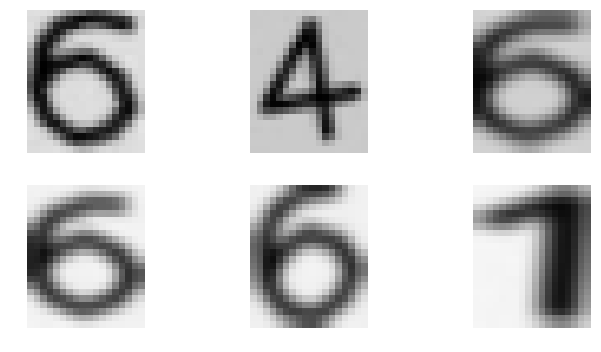

38

In [31]:

datax_train = np.array(numberDataDictionary["image"])
datay_train = np.array(numberDataDictionary["vector"])

data_training_generator = realDataGen.flow(datax_train,datay_train,batch_size=20)
# validation_generator = realDataGen.flow(datax_train, datay_train, batch_size=64,subset='validation')

plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in data_training_generator:
        plt.imshow((x[0]/255),cmap='gray')
#         plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()
len(datax_train)

In [46]:
LEARNING_RATE = 1e-4
number_loaded_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])


In [47]:

history_conv = number_loaded_model.fit_generator(data_training_generator,steps_per_epoch=(len(datax_train))//20, epochs=60, validation_data=data_training_generator, validation_steps=(len(datax_train))//20)

Epoch 1/60
1/1 [==============================] - 1s 785ms/step - loss: 0.6896 - acc: 0.6500 - val_loss: 0.9276 - val_acc: 0.7000
Epoch 2/60
1/1 [==============================] - 0s 89ms/step - loss: 1.2470 - acc: 0.6111 - val_loss: 0.0546 - val_acc: 1.0000
Epoch 3/60
1/1 [==============================] - 0s 155ms/step - loss: 1.1968 - acc: 0.5500 - val_loss: 0.1454 - val_acc: 0.9500
Epoch 4/60
1/1 [==============================] - 0s 80ms/step - loss: 0.8759 - acc: 0.6667 - val_loss: 0.1452 - val_acc: 0.9444
Epoch 5/60
1/1 [==============================] - 0s 209ms/step - loss: 0.6625 - acc: 0.7778 - val_loss: 0.1133 - val_acc: 1.0000
Epoch 6/60
1/1 [==============================] - 0s 139ms/step - loss: 0.2878 - acc: 0.9000 - val_loss: 0.0582 - val_acc: 1.0000
Epoch 7/60
1/1 [==============================] - 0s 182ms/step - loss: 0.4793 - acc: 0.8000 - val_loss: 0.0433 - val_acc: 1.0000
Epoch 8/60
1/1 [==============================] - 0s 56ms/step - loss: 0.3032 - acc: 0.8333 

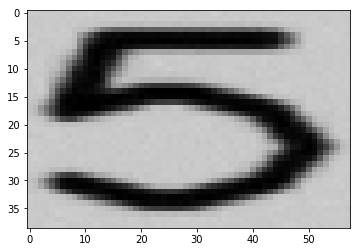

In [48]:
# test the model
def testModel(img,truth):
  grayImg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img_aug = np.repeat(grayImg[..., np.newaxis], 3, -1)
  img_aug = cv2.resize(img_aug,(inputWidth,inputHeight))
  img_aug = np.expand_dims(img_aug, axis=0)
  y_predict = number_loaded_model.predict(img_aug)[0]
#   print(y_predict)
  plt.imshow(img)
  predictVal = max(y_predict)
#   print(predictVal)
  predictedVal_index = np.where(y_predict == predictVal)[0][0]
  predictedVal = numberLabels[predictedVal_index]
#   groundTruth_index = np.where(datay_train[index] == 1)[0][0]
#   groundTruth = labels[groundTruth_index]
#   print("predicted value:",format(predictedVal))
#   print("ground truth:",format(truth))
  if (predictedVal != truth):
   print("predicted value:",format(predictedVal))
   print("ground truth:",format(truth))


dataPath = "./realData/parkingNumbers"

for file in os.listdir(dataPath):
    if(file.endswith('.png')):
        truth = file[0]
        image = cv2.imread(dataPath + '/' + file) #converts to grey scale
        width, height, dim = image.shape
#         image = cv2.resize(image,(95,170))
        plt.imshow(image)
        testModel(image,truth)

In [50]:
number_loaded_model.save("numberswithparking.h5")